In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio

import os
import pickle
import json

from tqdm import tqdm_notebook

In [2]:
#path_dataset = '../input/'
path_dataset = '/home/edoardobucheli/Datasets/FSDKaggle2018'

path_train = os.path.join(path_dataset,'audio_train_16k')
path_test = os.path.join(path_dataset,'audio_test_16k')

### Load Label Data

In [3]:
train_data = pd.read_csv(os.path.join(path_dataset,'train_post_competition.csv'))
test_data = pd.read_csv(os.path.join(path_dataset,'test_post_competition_scoring_clips.csv'))

In [4]:
from utilities import get_all_classes_dict, get_classes_to_meta_dict, get_labels

In [5]:
num_to_label, label_to_num, n_classes = get_all_classes_dict(train_data)
label_to_meta, label_num_to_meta = get_classes_to_meta_dict(label_to_num)

In [6]:
data_cur = train_data[train_data['manually_verified']==1]
data_noi = train_data[train_data['manually_verified']==0]

In [7]:
meta_labels_all, labels_all = get_labels(train_data,label_to_meta, label_to_num)
meta_labels_cur, labels_cur = get_labels(data_cur,label_to_meta, label_to_num)
meta_labels_noi, labels_noi = get_labels(data_noi,label_to_meta, label_to_num)
meta_labels_test, labels_test = get_labels(test_data,label_to_meta, label_to_num)

In [8]:
n_meta_classes = len(np.unique(meta_labels_all))

In [9]:
is_curated = train_data['manually_verified'].tolist()
indx_curated = [i for i,f in enumerate(is_curated) if f == 1]

### Load Data

In [10]:
pickle_train = './preprocessed_train/MS-80-HL512-WF16k-64k'
pickle_test = './preprocessed_test/MS-80-HL512-WF16k-64k'

In [11]:
with open(pickle_train,'rb') as fp:
    x_train = pickle.load(fp)
with open(pickle_test, 'rb') as fp:
    x_test = pickle.load(fp)

### Separate Curated and MC

In [12]:
x_cur = [x_train[f] for f in indx_curated]

In [13]:
my_x = x_train
meta_labels = meta_labels_all
my_labels = labels_all

In [14]:
indx_mc = [i for i,f in enumerate(meta_labels) if f == 5]

In [15]:
x_mc = [my_x[f] for f in indx_mc]
labels_mc = [my_labels[f] for f in indx_mc]
labels_name_mc = [num_to_label[f] for f in labels_mc]

mc_new_label_mapping = dict([[f,i] for i,f in enumerate(np.unique(labels_mc))])
new_train_labels_mc = [mc_new_label_mapping[f] for f in labels_mc]

In [16]:
indx_unk = [i for i in np.random.randint(0,len(my_x),len(x_mc))if i not in indx_mc]
x_unk = [my_x[f] for f in indx_unk]
labels_unk = np.ones((len(indx_unk),))*(len(np.unique(new_train_labels_mc)))

In [17]:
x_mc_2 = x_mc + x_unk
new_train_labels_mc.extend(labels_unk)

In [18]:
#with open('./c0_mapping','wb') as fp:
#    pickle.dump(c0_new_label_mapping,fp)

In [19]:
indx_test_mc = [i for i,f in enumerate(meta_labels_test) if f == 5]

In [20]:
x_test_mc = [x_test[f] for f in indx_test_mc]
labels_test_mc = [labels_test[f] for f in indx_test_mc]
new_test_labels_mc = [mc_new_label_mapping[f] for f in labels_test_mc]

In [21]:
indx_unk_test = [i for i in np.random.randint(0,len(x_test),len(x_test_mc)) if i not in indx_test_mc]
x_unk_test = [x_test[f] for f in indx_unk_test]
labels_unk_test = np.ones((len(indx_unk_test),))*(len(np.unique(new_test_labels_mc)))

In [22]:
x_test_mc_2 = x_test_mc+x_unk_test
new_test_labels_mc.extend(labels_unk_test)

In [23]:
sr = 16000
file_length = sr*4
hop_length = 512
n_mels = 80

frames = int(np.ceil(file_length/hop_length))

# Malley CNN

In [24]:
from CNNetworks2D import malley_cnn_80
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

In [25]:
input_shape = ([n_mels,frames])
lr = 0.001
model = malley_cnn_80(input_shape,41)
model.load_weights('./weights_m41.h5')
#model.summary()

In [26]:
new_output_name = 'global_max_pooling2d'
new_output_layer = model.get_layer(new_output_name).output
model_headless = tf.keras.Model(inputs = model.input, outputs = new_output_layer)

In [27]:
#model_headless.trainable = False

In [28]:
X = tf.keras.layers.Dense(512,activation='relu')(model_headless.output)
X = tf.keras.layers.Dropout(0.5)(X)
X = tf.keras.layers.Dense(len(mc_new_label_mapping)+1, activation = 'softmax')(X)

In [29]:
model = tf.keras.Model(inputs = model_headless.input, outputs = X)

In [30]:
for l in model.layers[:13]:
    l.trainable = False

In [31]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 80, 125)           0         
_________________________________________________________________
expand_dims (Lambda)         (None, 80, 125, 1)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 80, 125, 64)       1408      
_________________________________________________________________
activation (Activation)      (None, 80, 125, 64)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 40, 125, 64)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 40, 125, 128)      57472     
_________________________________________________________________
activation_1 (Activation)    (None, 40, 125, 128)      0         
__________

In [32]:
model.compile(optimizer=Adam(lr),loss = 'sparse_categorical_crossentropy',metrics = ['accuracy'])

### Make Generators

In [33]:
from data_generator import DataGenerator

In [34]:
new_order = np.arange(len(x_mc_2))
np.random.shuffle(new_order)

In [35]:
x_mc_2 = [x_mc_2[i] for i in new_order]
new_train_labels_mc = [new_train_labels_mc[i] for i in new_order]

In [36]:
train_generator = DataGenerator(x_mc_2,new_train_labels_mc)
val_generator = DataGenerator(x_test_mc_2,new_test_labels_mc)

### Train the Model

In [37]:
model.fit_generator(train_generator,epochs = 25,validation_data=val_generator)

Epoch 1/25
14/14 [==============================] - 3s 191ms/step - loss: 0.9686 - acc: 0.6838 - val_loss: 0.1906 - val_acc: 0.9292
Epoch 2/25
14/14 [==============================] - 1s 83ms/step - loss: 0.3238 - acc: 0.8937 - val_loss: 0.1727 - val_acc: 0.9375
Epoch 3/25
14/14 [==============================] - 1s 85ms/step - loss: 0.2189 - acc: 0.9332 - val_loss: 0.1683 - val_acc: 0.9500
Epoch 4/25
14/14 [==============================] - 1s 84ms/step - loss: 0.2016 - acc: 0.9365 - val_loss: 0.1518 - val_acc: 0.9417
Epoch 5/25
14/14 [==============================] - 1s 84ms/step - loss: 0.1702 - acc: 0.9445 - val_loss: 0.1584 - val_acc: 0.9500
Epoch 6/25
14/14 [==============================] - 1s 83ms/step - loss: 0.1528 - acc: 0.9524 - val_loss: 0.1612 - val_acc: 0.9542
Epoch 7/25
14/14 [==============================] - 1s 85ms/step - loss: 0.1284 - acc: 0.9543 - val_loss: 0.1394 - val_acc: 0.9583
Epoch 8/25
14/14 [==============================] - 1s 95ms/step - loss: 0.1101 - 

In [38]:
x_test_mc = np.zeros((len(x_test_mc_2),80,125))

for i, this_x in enumerate(x_test_mc_2):
    
    this_frames = this_x.shape[1]
    
    if this_frames > 125:
        max_start = this_frames - 125
        start = np.random.randint(0,max_start)
        end = start+125

        this_x = this_x[:,start:end]
        
    x_test_mc[i] = this_x

In [39]:
model.evaluate(x_test_mc,new_test_labels_mc)

240/240 [==============================] - 0s 1ms/step


[0.16029720329485522, 0.9583333333333334]

In [40]:
y_scores = model.predict(x_test_mc)

In [41]:
y_hat_mc = np.argmax(y_scores, axis = 1)

### Plot Confussion Matrix

In [42]:
from utilities import plot_cm

In [43]:
mc_labels = list(mc_new_label_mapping.keys())

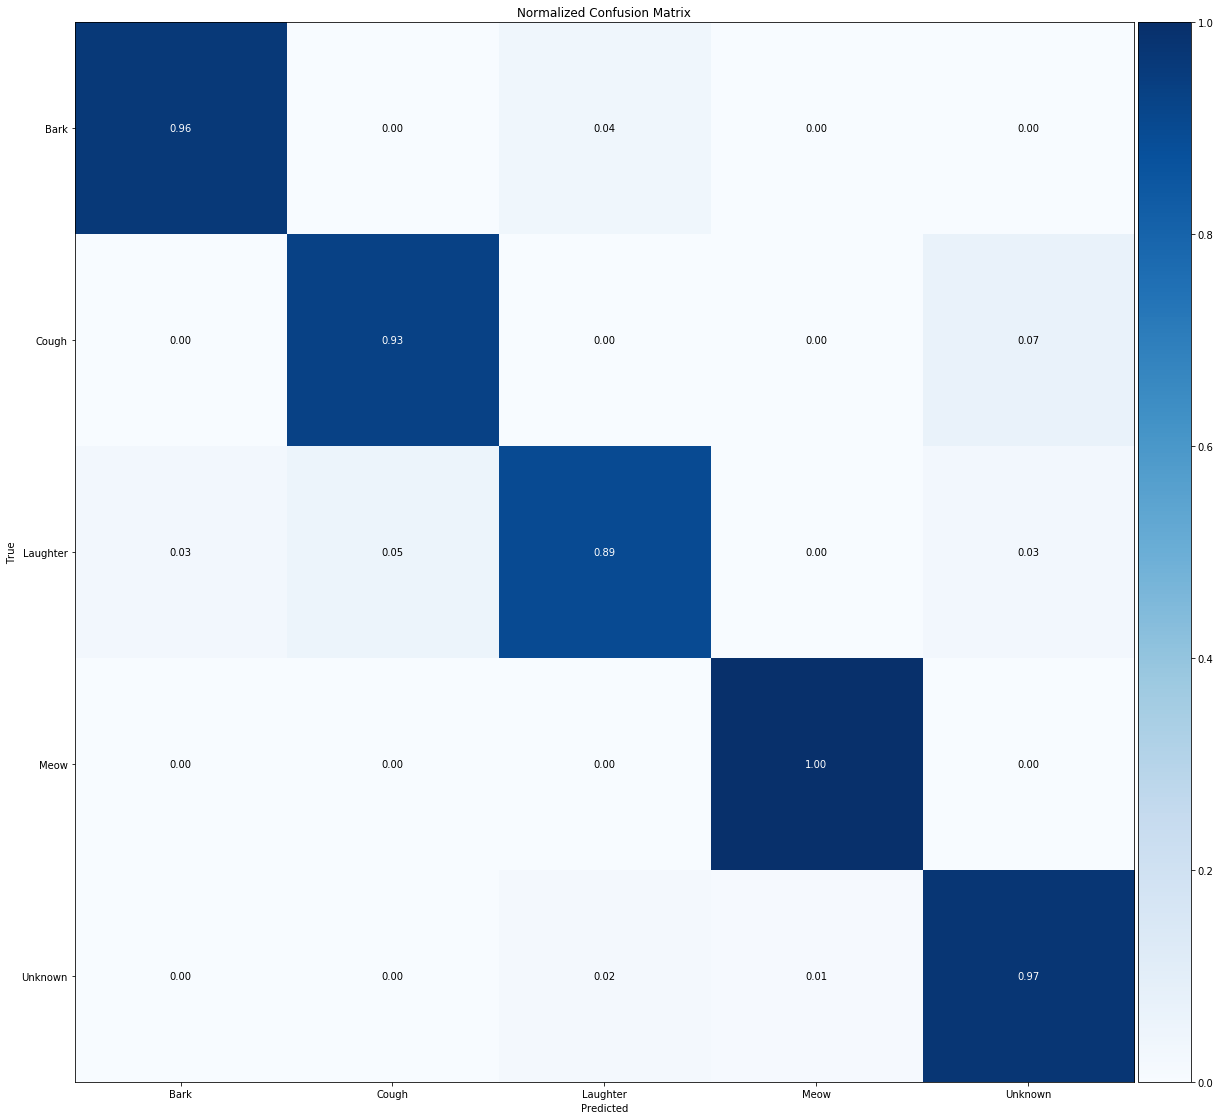

In [44]:
labels = [num_to_label[f] for f in mc_labels]
labels.append('Unknown')
plot_cm(new_test_labels_mc,y_hat_mc,figsize = (20,20), labels = labels,xrotation = 0)

In [45]:
model.save_weights('./weights_c5_malley_v2.h5')